# KAN Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LinearSpline(nn.Module):
    """
    A learnable piecewise linear activation function (linear spline).
    Knots are trainable and define the shape of the activation.
    """
    def __init__(self, num_knots=5, init_scale=0.1, input_range=3.0):
        super().__init__()
        self.num_knots = num_knots
        self.input_range = input_range

        # Linear spline parameters
        self.knot_x = nn.Parameter(torch.linspace(-input_range, input_range, num_knots))
        self.knot_y = nn.Parameter(torch.randn(num_knots) * init_scale)

        # Weight parameters for combining components
        self.w_spline = nn.Parameter(torch.tensor(1.0))  # Spline weight
        self.w_silu = nn.Parameter(torch.tensor(1.0))    # SiLU weight

    def forward(self, x):
        """
        Compute piecewise linear interpolation between knots.
        Args:
            x: Input tensor (any shape)
        Returns:
            Output tensor (same shape as x)
        """
        # Clamp input to valid range
        x_clamped = torch.clamp(x, -self.input_range, self.input_range)

        # Compute spline component
        segments = torch.searchsorted(self.knot_x, x_clamped) - 1
        segments = segments.clamp(0, self.num_knots - 2)

        x0 = self.knot_x[segments]
        x1 = self.knot_x[segments + 1]
        y0 = self.knot_y[segments]
        y1 = self.knot_y[segments + 1]

        alpha = (x_clamped - x0) / (x1 - x0 + 1e-6)
        spline_out = y0 + alpha * (y1 - y0)

        return self.w_silu * F.silu(x) + self.w_spline * spline_out

class KANLayer(nn.Module):
    """
    A single KAN layer with learnable piecewise linear activations.
    Replaces a traditional linear layer.
    """
    def __init__(self, input_dim, output_dim, num_knots=5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Each edge has its own spline activation
        self.splines = nn.ModuleList([
            LinearSpline(num_knots) for _ in range(input_dim * output_dim)
        ])

    def forward(self, x):
        batch_size = x.shape[0]
        out = torch.zeros(batch_size, self.output_dim).to(x.device)

        # Apply each spline to its corresponding input
        for j in range(self.output_dim):
            for i in range(self.input_dim):
                spline_idx = i * self.output_dim + j
                out[:, j] += self.splines[spline_idx](x[:, i])

        return out

class KAN(nn.Module):
    """
    A simple KAN with 2 layers (input -> hidden -> output).
    """
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_knots=5):
        super().__init__()
        self.layer1 = KANLayer(input_dim, hidden_dim, num_knots)
        self.layer2 = KANLayer(hidden_dim, output_dim, num_knots)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x


In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=20, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Training on Toy Dataset and Analysis

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split

def generate_data(n_samples=5000, noise=0.1):
    x = np.random.uniform(-3, 3, (n_samples, 2))
    y = np.sin(x[:, 0]) + np.cos(x[:, 1]) + x[:, 0]**2 - x[:, 1]**2
    y += noise * np.random.randn(n_samples)
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(1)

def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []

    start_time = time()
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)
            val_losses.append(val_loss.item())

    training_time = time() - start_time
    return train_losses, val_losses, training_time

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = nn.MSELoss()(y_pred, y_test).item()
    return test_loss

Before training
Parameter containing:
tensor([-3.0000, -1.5000,  0.0000,  1.5000,  3.0000], requires_grad=True)
After training
Parameter containing:
tensor([-2.6001, -1.5993,  0.7701,  2.2047,  2.2902], requires_grad=True)

Metric               KAN        MLP       
----------------------------------------
Parameters           360        151       
Training Time (s)    54.00 1.93
Final Train MSE      0.4455 0.1998
Final Val MSE        0.4656 0.2047
Test MSE             0.4103 0.1945


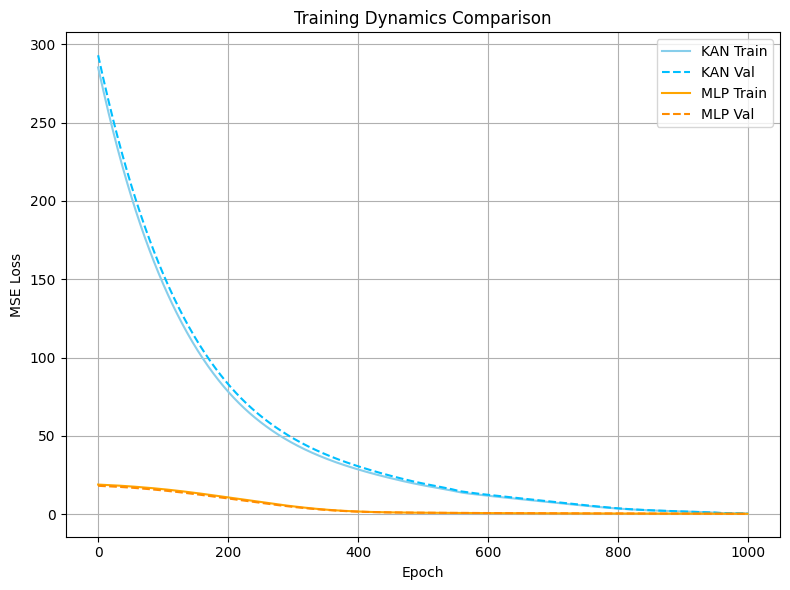

In [4]:
# Generate and split data (60/20/20)
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25*0.8=0.2

# Initialize models
# hidden_dim = 10
kan = KAN(input_dim=2, hidden_dim=10, num_knots=5)
mlp = MLP(input_dim=2, hidden_dim=10)

print('Before training')
print(kan.layer1.splines[0].knot_x)

# Train models with validation
kan_train, kan_val, kan_time = train_model(kan, X_train, y_train, X_val, y_val)
mlp_train, mlp_val, mlp_time = train_model(mlp, X_train, y_train, X_val, y_val)

print('After training')
print(kan.layer1.splines[0].knot_x)

# Final evaluation on test set
kan_test = evaluate_model(kan, X_test, y_test)
mlp_test = evaluate_model(mlp, X_test, y_test)

# Count parameters
kan_params = sum(p.numel() for p in kan.parameters())
mlp_params = sum(p.numel() for p in mlp.parameters())

# Results
print(f"\n{'Metric':<20} {'KAN':<10} {'MLP':<10}")
print(f"{'-'*40}")
print(f"{'Parameters':<20} {kan_params:<10} {mlp_params:<10}")
print(f"{'Training Time (s)':<20} {kan_time:.2f} {mlp_time:.2f}")
print(f"{'Final Train MSE':<20} {kan_train[-1]:.4f} {mlp_train[-1]:.4f}")
print(f"{'Final Val MSE':<20} {kan_val[-1]:.4f} {mlp_val[-1]:.4f}")
print(f"{'Test MSE':<20} {kan_test:.4f} {mlp_test:.4f}")

# Plotting combined validation curves
plt.figure(figsize=(8, 6))

plt.plot(kan_train, label='KAN Train', color='skyblue', linestyle='-')
plt.plot(kan_val, label='KAN Val', color='deepskyblue', linestyle='--')
plt.plot(mlp_train, label='MLP Train', color='orange', linestyle='-')
plt.plot(mlp_val, label='MLP Val', color='darkorange', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Dynamics Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

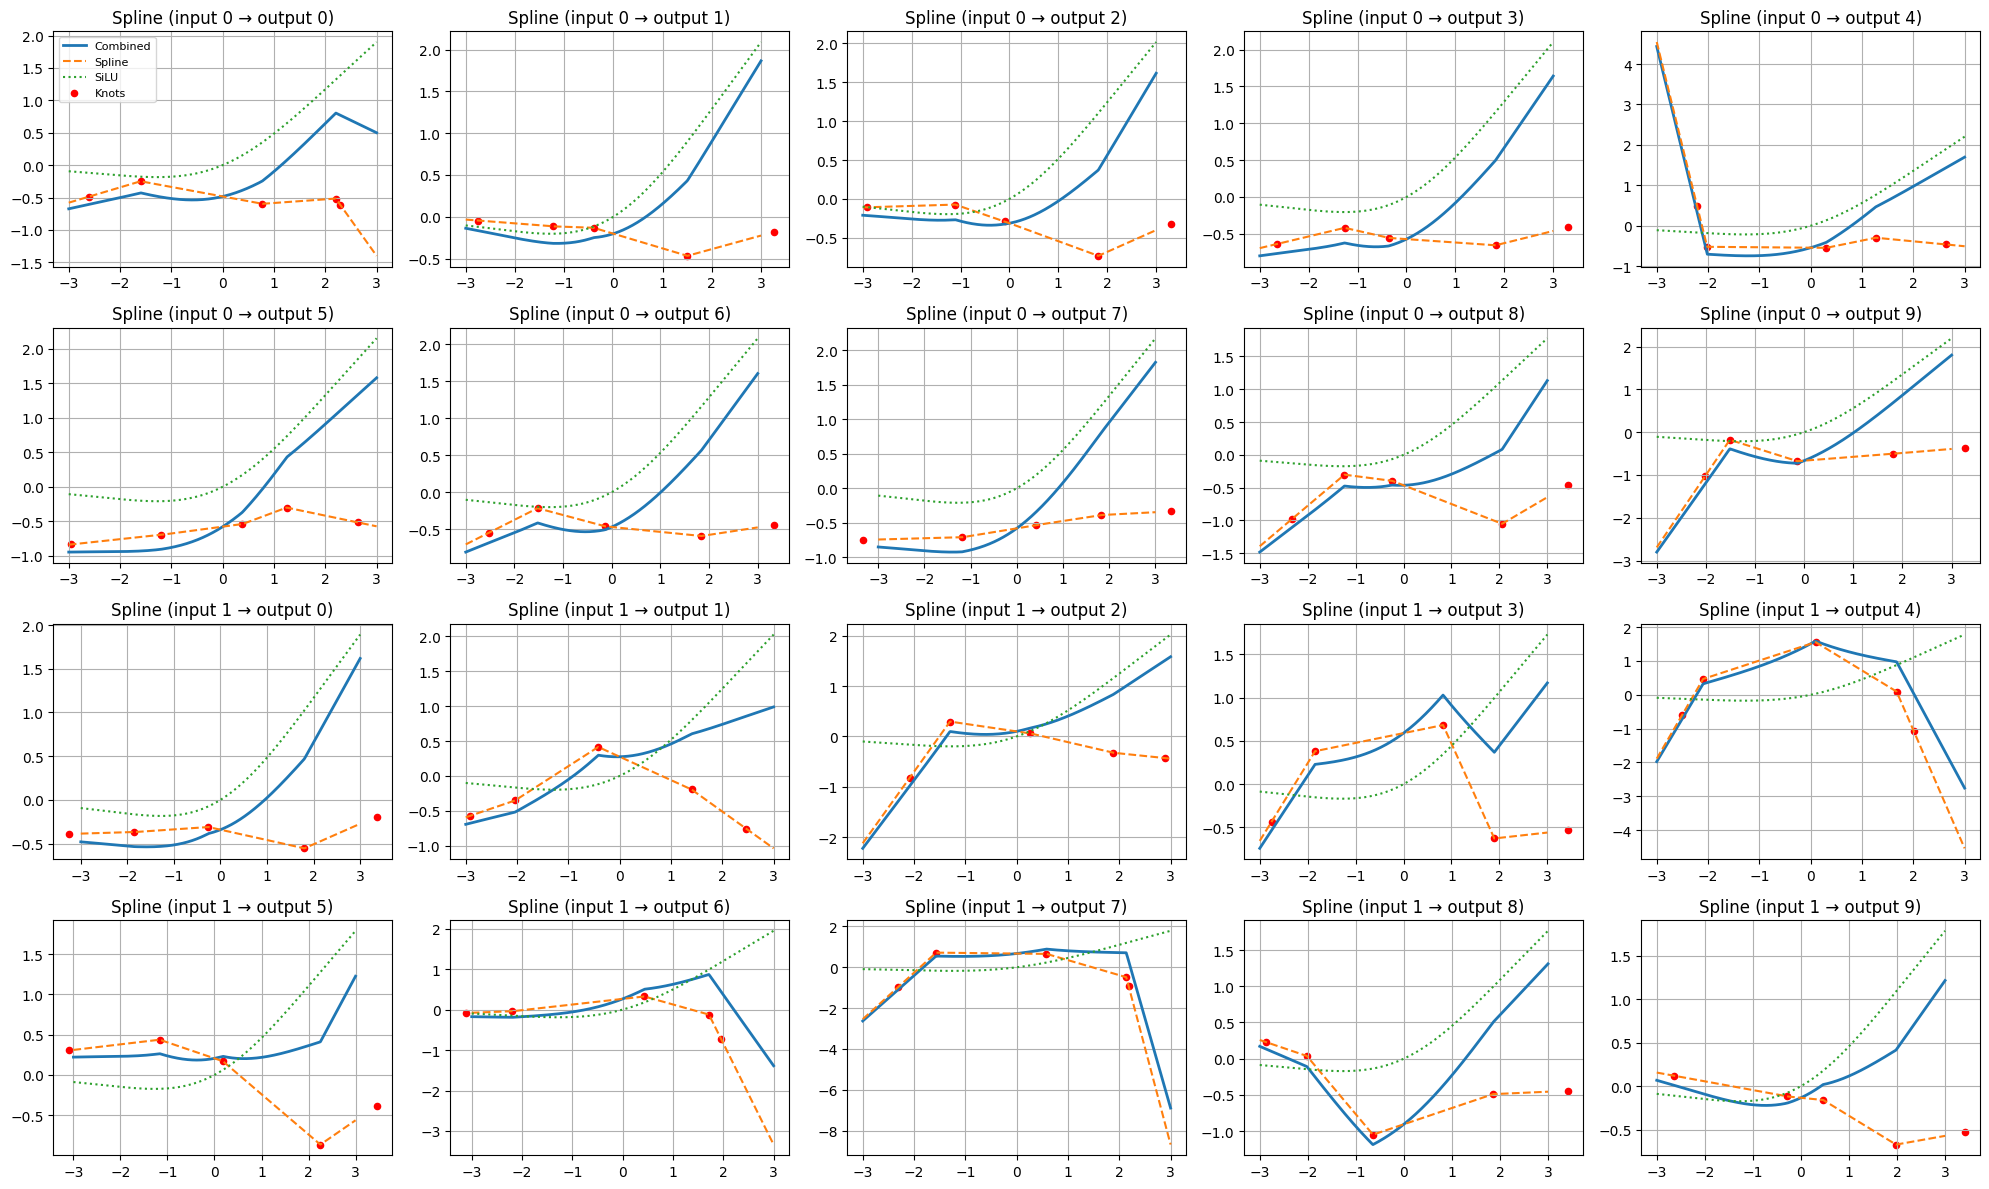

In [5]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def compute_spline_component(spline: LinearSpline, x: torch.Tensor):
    """
    Compute the spline output for input x using the spline's knots.
    Returns the spline output tensor.
    """
    x_clamped = torch.clamp(x, -spline.input_range, spline.input_range)
    segments = torch.searchsorted(spline.knot_x, x_clamped) - 1
    segments = segments.clamp(0, spline.num_knots - 2)

    x0 = spline.knot_x[segments]
    x1 = spline.knot_x[segments + 1]
    y0 = spline.knot_y[segments]
    y1 = spline.knot_y[segments + 1]

    alpha = (x_clamped - x0) / (x1 - x0 + 1e-6)
    spline_out = y0 + alpha * (y1 - y0)
    return spline_out

def plot_kan_layer_activations(kan_layer: KANLayer, max_plots_per_row=5):
    device = next(kan_layer.parameters()).device
    num_splines = len(kan_layer.splines)

    rows = math.ceil(num_splines / max_plots_per_row)
    cols = min(num_splines, max_plots_per_row)

    plt.figure(figsize=(cols * 4, rows * 3))

    input_range = kan_layer.splines[0].input_range
    x_np = torch.linspace(-input_range, input_range, 500).to(device)

    for idx, spline in enumerate(kan_layer.splines):
        with torch.no_grad():
            y = spline(x_np)
            spline_out = compute_spline_component(spline, x_np)
            silu_out = F.silu(x_np)

        ax = plt.subplot(rows, cols, idx + 1)
        ax.plot(x_np.cpu().detach(), y.cpu().detach().numpy(), label="Combined", linewidth=2)
        ax.plot(x_np.cpu().detach(), (spline.w_spline * spline_out).cpu().detach().numpy(), linestyle='--', label="Spline")
        ax.plot(x_np.cpu().detach(), (spline.w_silu * silu_out).cpu().detach().numpy(), linestyle=':', label="SiLU")
        ax.scatter(spline.knot_x.cpu().detach(), (spline.w_spline * spline.knot_y).cpu().detach(), color='red', s=20, label="Knots")

        input_dim = kan_layer.input_dim
        output_dim = kan_layer.output_dim
        i = idx // output_dim
        j = idx % output_dim
        ax.set_title(f"Spline (input {i} → output {j})")
        ax.grid(True)

        if idx == 0:
            ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


plot_kan_layer_activations(kan.layer1)